### Problem statement:
Gdoc: https://docs.google.com/document/d/1xYIV3xRNxTjUaw1fBkwB0ujJxUH6l7Gc1Mrskzny6JI/edit?usp=sharing

Trying to track ROI target by adjusting cpc - assume that RPC doesnt change w/ cpc
```
ROI_obs = RPC_obs / CPC_obs
ROI_target = RPC_obs / CPC_target
ROI_obs * CPC_obs = ROI_target * CPC_target
CPC_target = ROI_obs/ROI_target * CPC_obs = RPC_obs / ROI_target
```
Currently we calculate `RPC_obs` against real data - but monietization data may be spares - or u may have to go so far in the past that it no longer apllies to present

Can use lead score as way to leverage more plentiful session data - w/o relying on monetization events

Can split `RPC_obs` into 2 factors and a bias term: `RPQ_obs`, `QPS_obs`, and `R0` (revenue at 0 quality).  Quality is an abstract unit - the idea is that is is derived from lead score and roughly linear w/ revenue on a session level basis.  Ideally - we want to be able to calculate quality w/in sql and aggregate it at query time so we dont have to work w/ session level data.  `QPS_obs` can be aggregated w/in a modifier bucket - using plentiful session data.  `RPQ_obs` can be aggregated accross the dataset - under the assumption that `RPQ_obs` will be stable accross an entire channel/platform/product - and possibly b/w platforms/products
```
RPC_obs = (RPQ_obs * QPS_obs + R0)
CPC_target = RPC_obs / ROI_target = (RPQ_obs * QPS_obs + R0) / ROI_target
```

### Domain
Biddable Dimensions:
1. Location (DMA)
2. Operating System
3. Device Type
4. Publisher (website ad was served on)
5. Time of Day

Split will most likely be on `(DMA,OS,Device)`.  Unsure if there will be enough session level data to support splitting on dimensions beyond that.  We might have to consider some split variables in isolation.  Alternately - we could try using a k-means or percentile-based clustering method to group our data w/in a very fine grained split.

### Evaluation
Bascially we want this `rps` estimation to capture long term trends w/o short term  noise.  Ideas:
1. plot out rolling 1,7,14,30,60,90 day estimates of rps using regular aggregations and using the lead score stabilized rps estimate
    - want time plots and histograms
1. compare the rps esimation to rolling rps w/ large window
    - at that pt - why not use that rolling rps to estimate?
1. if the idea is that we are compensating for data deficiency - why dont we use large buckets to measure bias - and small buckets to measure variance - than combine into some metric?

### Initial approach
Will just naively use `lead_score` as a standin for quality - I think that ultimately precision at that lead score would be the best quality metric - since it basically corresponds to observed conversion rate.  But I think that is best accomplished on @sperks side.  Lets see how this goes first.

For a given split - I will pull in revenue averages, bucket size, and lead score averages for each bucket.  Will compute `RPQ_obs` and `R0` by fitting a 1 var regressor w/ `y=rps_avg` and `X=[lead_score_avg]` - will use `bucket size` as sample weight.

NOTE: i guess there are actually 2 differnt model scores per lead - I will pivot those out and the linear regressor will have 2 weights - 1 for each model score

### TODO
- use longer lookback period to take advantage of lead score time stability
- normalizing rev / session, then go from lead score => normalized RPS
    - then u could use observed mean RPS for that day to translate the lead score prediced noramlized RPS?
    ```
    RPS_obs = RPS_mu_obs * RPS_muadj_obs
    RPS_est = RPS_mu_obs * RPS_muadj_est =
        RPS_mu_obs * (w1*Q1PS + w2*Q2PS + w3*Q3PS + RPS_muadj_0)
    ```
    - how does this help?
        - `RPS_mu_obs` is calcualted using entire days data
            - it can capture changes in monetization over time
                - partners are less willing to buy leads at auction
                - stephen rolls out a new program that increases RPL
                - we monetize better w/ ISC
                - sesaonoal change
            - 
        - `RPS_muadj_est` can be calculated
    - what does this lose?
        - different buckets w/in a split may vary w/ time in different ways - this method does not let you capture that - althought you may update your `RPS_muadj_est` values periodically
        
- minimum # of lead scores to predict rev? - wasnt sure how to calculate this?
- no session w/in bucket?
    - traffic trap
        - side note? - set budget for exploration?
        - 
- ok - is this the mtd?
    - assume that all buckets in split vary w/ time proportionally?
    - modulate bucket RPS mean w/ whole day normalized RPS?
    - so we basically discard whole day mean RPS and bucket level variation
    - of course -we could also use like QPS somehow - but lead scores are actually sparser than rev data

### Approach 2:
#### Problem:
- RPC composed of 2 factors: `RPC = RPL * LPC`
    - RPL may change over time in ways that are out of the scope of adtech
        - E.g:
            - partners are less willing to buy leads at auction
            - stephen rolls out a new program that increases RPL
            - we monetize better w/ ISC
            - sesaonoal change
        - may also vary w/ buckets in a split - but think we might want to ignore this effect 
    - LPC - *THEORY* may be more stable over time
        - may itself be split into 2 factors (or a regression) `LPC = LPQ * QPC + L0`
        - we will try to capture diffference b/w split buckets w/ this term
        - QPC: just model lead score - actually a vector of 3 scores
            - should be stable against time - for a given model & version
            - assume
                - the lead score model doesnt use seasonal time inputs => seasonal invariant
                - any variable we may split on is taken into account by the model 
                    => QPC w.in buckets is accurate and should be roughly linear w/ underlying conversion rate for that bucket
        - LPQ:
            - fitting/normalization term to convert model score into conversion probability
            - may be able to capture some seasonal effects in conversion rate
        - Q: is there any benefit to factoring LPC ito QPC and LPQ - i.e. using lead score?
- overall `RPC = RPC * (LPQ*QPC + L0)`
- some problems w/ lead scores - did not find they were more plentify than rev data (less in fact)
- so will probably have to cluster or group w/in splits somehow - same is true of every method I think
- methods of overcoming data sparsity
    - davids bidder:
        - using large time window
        - data rollup
        - time discounting 
    - TOD modifiers:
        - use prior knowledge about nature of variable to smooth data and let buckets inform other buckets
    - taboola account structure
        - cluster buckets w/in split and group their data
- how to evaluate methods?
    - can split on a non-granular varaible (e.g. platform+os) and a random granular variable
    - can simulate a monetization change event w/ a step function on RPL 
    - we then know the underlying RPC of this super granular split pretty well
    - we also know what kind of time-dependence we want
    - we can evaluate methods on how well they estimate the underlying RPC and capture the time-dependence
- 4 overall methods of estimating RPC w/in buckets:
    * NOTE: can separately decide whether to 
        1. cluster the split before hand
        2. do some kind of time-discounting
        3. data rollup < NOTE: wont do this one 
    1. directly measure `RPC` over some time window
        - can vary time window
    2. factor `RPC` into `RPL * LPC`
        - can measure RPL over a shorter time window disgarding split and `LPC` over a longer time window
        - can try out some different time windows
        - NOTE: equivalent to the `RPC_mu * RPC_muadj_est` method
    3.factor `RPC` into `RPL * (LPQ * QPC + L0)`
        - can measure RPL over a short time window and fit LPC over a longer time window

In [30]:
import sys
import re
import os
# detect if we are running from a `notebooks/*_shared` folder
# re.match("not.*shared",sys.path[0])
if sys.path[0].endswith("_shared"):
    sys.path[0] = "/".join(sys.path[0].split("/")[:-2])
assert sys.path[0].endswith("adtech")

from utils.env import load_env_from_aws
load_env_from_aws()


from ds_utils.db.connectors import HealthcareDW
from notebooks.aduriseti_shared.utils import *

import functools
import datetime
TABOOLA = "TABOOLA"
MEDIA_ALPHA = "MEDIAALPHA"
BING = "BING"
U65 = "HEALTH"
O65 = 'MEDICARE'

NOW = datetime.datetime.now()
DAY = datetime.timedelta(days=1)

start_date = datetime.datetime(2021,4,1).date()
end_date = NOW
# start_date = NOW-30*DAY
# end_date = NOW
# start_date = NOW-60*DAY
# end_date = NOW-30*DAY
product=None
traffic_source = None

from models.data.queries.lead_score import \
    refresh_session_scores, \
    SCHEMA as DS_SCHEMA, \
    SCORE_TABLE
# df = refresh_session_scores(NOW-360*DAY,NOW)
# df

import functools

def get_unified_session_sql(start_date,end_date,product,traffic_source):
    start_date = start_date.date() if isinstance(start_date,datetime.datetime) else start_date
    end_date = end_date.date() if isinstance(end_date,datetime.datetime) else end_date
    product_filter = "" if product is None else \
        f"AND UPPER(s.product) = UPPER('{product}')"
    traffic_filter = "" if traffic_source is None else \
        f"AND UPPER(s.traffic_source) = UPPER('{traffic_source}')"

    session_revenue_sql = f"""
    SELECT
        session_id,
        sum(revenue) AS revenue
    FROM tron.session_revenue s
    WHERE session_creation_date::DATE BETWEEN '{start_date}' AND '{end_date}'
        {product_filter}
        {traffic_filter}
    GROUP BY 1
    """
    geoip_sql = f"""
    SELECT 
        l.*,
        b.netowrk_index,
        b.start_int,
        b.end_int
    FROM 
        data_science.maxmind_ipv4_geo_blocks AS b
        JOIN data_science.maxmind_geo_locations AS l
            ON b.maxmind_id = l.maxmind_id
    """
    score_pivot_sql = f"""
        SELECT  
            session_id,
            computed_dt,
            MAX(score_null) AS score_null,
            MAX(score_adv) AS score_adv,
            MAX(score_supp) AS score_supp
        FROM {DS_SCHEMA}.{SCORE_TABLE} 
        WHERE 
            '{start_date}'::DATE <= computed_dt AND computed_dt < '{end_date}'::DATE 
        GROUP BY
            session_id,computed_dt
    """
    session_score_sql = f"""
        SELECT 
            *
        FROM (
            SELECT  
                *,
                ROW_NUMBER() OVER (PARTITION BY session_id ORDER BY computed_dt DESC) as compute_order
            FROM ({score_pivot_sql})
        )
        WHERE compute_order = 1
    """
    unified_session_sql = f"""
    WITH
        rps AS ({session_revenue_sql}),
        ip_locs AS ({geoip_sql}),
        lead_scores AS ({session_score_sql})
    SELECT
        s.traffic_source,
        s.browser,
        s.operating_system,
        s.device,
        s.channel,
        s.domain,
        s.product,
        s.keyword,
        s.campaign_id,
        s.landing_page,
        s.session_id,
        s.creation_date::DATE                                   AS utc_dt,
        s.creation_date                                         AS utc_ts,
        extract(
            HOUR FROM
            convert_timezone('UTC', l.time_zone, s.creation_date) 
                - s.creation_date
        )::INT                                                  AS utc_offset,
        l.time_zone,
        convert_timezone('UTC', l.time_zone, s.creation_date)   AS user_ts,
        date_part(DOW, user_ts)::INT                            AS dayofweek,
        date_part(HOUR, user_ts) +
        CASE 
            WHEN date_part(MINUTE, user_ts)::INT BETWEEN 0 AND 14 THEN 0.0
            WHEN date_part(MINUTE, user_ts)::INT BETWEEN 15 AND 29 THEN 0.25
            WHEN date_part(MINUTE, user_ts)::INT BETWEEN 30 AND 44 THEN 0.5
            WHEN date_part(MINUTE, user_ts)::INT BETWEEN 45 AND 59 THEN 0.75
        END                                                     AS hourofday,
        l.subdivision_1_iso_code                                AS state,
        l.metro_code                                            AS dma,
        r.revenue,
        scores.computed_dt                                      AS score_compute_dt,
        scores.score_null,
        scores.score_adv,
        scores.score_supp,
        (random() * 4)::INT                                     AS random_split_4,
        (random() * 8)::INT                                     AS random_split_8,
        (random() * 16)::INT                                    AS random_split_16,
        (random() * 32)::INT                                    AS random_split_32,
        (random() * 64)::INT                                    AS random_split_64,
        (random() * 128)::INT                                   AS random_split_128
    FROM 
        tracking.session_detail AS s
        JOIN ip_locs as l
            ON ip_index(s.ip_address) = l.netowrk_index
            AND inet_aton(s.ip_address) BETWEEN l.start_int AND l.end_int
            AND l.country_iso_code = 'US'
        INNER JOIN rps as r
            ON s.session_id = r.session_id
        LEFT JOIN lead_scores as scores
            ON s.session_id = scores.session_id
    WHERE nullif(s.ip_address, '') IS NOT null
        AND nullif(dma,'') IS NOT NULL 
        AND s.creation_date::DATE BETWEEN '{start_date}' AND '{end_date}'
        {product_filter}
        {traffic_filter}
    """
    return unified_session_sql

@functools.lru_cache()
def unified_session(start_date,end_date,product,traffic_source):
    unified_session_sql = get_unified_session_sql(start_date,end_date,product,traffic_source)
    
    with HealthcareDW() as db:
        session_df = db.to_df(unified_session_sql)
    return session_df
    
@functools.lru_cache()
def agg_rps(start_date,end_date,product,traffic_source,agg_columns):

    # from IPython.display import display as ipydisp
    # score_computed_I = ~session_rps_df["score_compute_dt"].isna()
    # session_rps_df["score_computed"] = score_computed_I
    # session_rps_df["rev>0"] = session_rps_df["revenue"] > 0
    # session_rps_df["cnt"] = 1
    # session_rps_df.groupby(["score_computed","rev>0"])[["cnt"]].count()

    agg_columns = [*agg_columns]
    unified_session_sql = get_unified_session_sql(start_date,end_date,product,traffic_source)
    agg_rps_query = f"""
    SELECT
        {','.join(agg_columns)},
        COUNT(session_id)                                                       AS sessions,
        SUM(revenue)                                                            AS revenue,
        SUM((revenue>0)::INT::FLOAT)                                            AS num_leads,
        AVG((revenue>0)::INT::FLOAT)                                            AS lps_avg,
        SUM(revenue) / CASE
            WHEN num_leads = 0 THEN 1
            ELSE num_leads
        END                                                                     AS rpl_avg,
        (SUM(revenue) / COUNT(DISTINCT session_id))::NUMERIC(8,4)               AS rps_,
        AVG(revenue)                                                            AS rps_avg,
        STDDEV(revenue)                                                         AS rps_std,
        VARIANCE(revenue)                                                       AS rps_var,
        SUM((score_null>0)::INT)                                                AS score_null_cnt,
        AVG(score_null)                                                         AS score_null_avg,
        SUM((score_adv>0)::INT)                                                 AS score_adv_cnt,
        AVG(score_adv)                                                          AS score_adv_avg,
        SUM((score_supp>0)::INT)                                                AS score_supp_cnt,
        AVG(score_supp)                                                         AS score_supp_avg,
        SUM(((score_null>0) OR (score_adv>0) OR (score_supp>0))::INT)           AS score_cnt
    FROM ({unified_session_sql})
    GROUP BY {','.join(agg_columns)}
    """
    # print(agg_rps_query)
    # print(traffic_filter)
    from ds_utils.db.connectors import HealthcareDW
    with HealthcareDW() as db:
        df = db.to_df(agg_rps_query)
    globals()["df"] = df

    delt = df["rps_avg"] - df['rps_']
    if not all(delt.abs() < 1e-3):
        print("session uniqueness assummption not satisfied")
    df = df \
        .sort_values(by=agg_columns, ascending=True) \
        .set_index(agg_columns)

    df['int_ix'] = range(len(df))

    return df

Attempting to load environ from: `SM_ENV_BASE`
...Success!!


sessions          939751.0
num_leads          72695.0
score_null_cnt     29163.0
score_adv_cnt       7103.0
score_supp_cnt      7105.0
score_cnt          36265.0
dtype: float64

rpl       lps
device  random_split_128 utc_dt                         
DESKTOP 0                2021-03-07   5.550000  0.142857
                         2021-03-08  48.206667  0.103448
                         2021-03-09  12.866667  0.100000
                         2021-03-10   8.330000  0.071429
                         2021-03-11  23.445000  0.166667
...                                        ...       ...
TABLET  127              2021-06-01        NaN  0.000000
                         2021-06-02  10.500000  0.200000
                         2021-06-03        NaN  0.000000
                         2021-06-04   2.932920  0.028571
                         2021-06-05        NaN       NaN

[34944 rows x 2 columns]

DESKTOP
MOBILE
TABLET


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


{'MAE': 1.265270717905693, 'MSE': 3.7906873484516233}

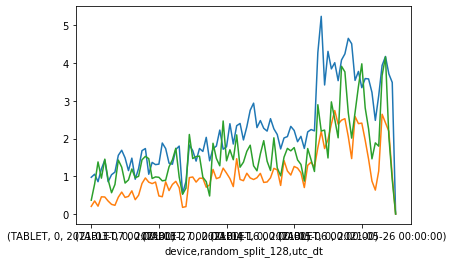

In [47]:
campaign_split_fields = dict(
    # traffic_source = ["traffic_source"],
    browser = ["browser"],
    operating_system = ["operating_system"],
    device = ["device"],
    # channel = ["channel"],
    # domain = ["domain"],
    product = ["product"],
    # keyword = ["keyword"],
    # campaign_id = ["campaign_id"],
    # landing_page = ["landing_page"],
    TOD = ["dayofweek","hourofday"],
    dma = ["dma"],
    state =["state",],
    location = ["state","dma"],
    
    dma_os=["dma", "operating_system"],
    dma_device=["dma", "device", ],
    dma_os_device=["dma", "operating_system", "device"],

    state_os=["state", "operating_system"],
    state_device=["state", "device", ],
    state_os_device=["state", "operating_system", "device"],

    location_os = ["state", "dma", "operating_system"],
    location_device=["state", "dma", "device", ],
    location_os_device = ["state", "dma", "operating_system","device"],
)

taboola_val_map = {
    "device": {
        'DESKTOP': 'DESK',
        'MOBILE': 'PHON',
        'TABLET': 'TBLT',
    },
    "operating_system": {
        "Linux": "Linux",
        'Linux armv7l': "Linux",
        'Linux armv8l': "Linux",
        'Linux x86_64': "Linux",
        'MacIntel': 'Mac OS X',
        'Win32': "Windows",
        'iPad': "iPadOS",
        'iPhone': "iOS",
        '': None,
        'ARM': None,
        'Android': 'Android',
        'Linux aarch64': "Linux",
        'Win64': "Windows",
        'Linux armv7': "Linux",
        'Linux i686': "Linux",
        'Windows': "Windows",
        "iPod touch": "iOS",
    }
}

def translate_taboola_vals(df):
    index_cols = df.index.names
    df = df.reset_index()
    for c in df.columns:
        if c in taboola_val_map:
            df[c] = df[c] \
                .map(taboola_val_map[c]) \
                .combine_first(df[c])
    df_bkp = df
    df = df \
        .groupby(index_cols) \
        .agg({
            "sessions": sum,
            "num_leads": sum,
            "lps_avg": get_wavg_by(df,"sessions"),
            "rpl_avg": get_wavg_by(df,"sessions"),
            "rps_avg": get_wavg_by(df,"sessions"),
        })
    df["int_ix"] = range(len(df))
    df_bkp_wavg = wavg(df_bkp[["lps_avg","rpl_avg","rps_avg"]],
                        df_bkp["sessions"].values.reshape(-1, 1))
    df_wavg = wavg(df[["lps_avg","rpl_avg","rps_avg"]],
                    df["sessions"].values.reshape(-1, 1))
    assert all((df_bkp_wavg - df_wavg).abs() < 1e-2), (df_bkp_wavg,df_wavg)
    return df

import pprint
from IPython.display import display as ipydisp    
import pandas as pd
import numpy as np
from models.utils import wavg
import collections
import itertools

def wavg(V, W):
    if W.sum() == 0:return 0
    if V.shape.__len__() > 1:
        return (V*W.values.reshape(-1,1)).sum() / W.sum()
    else:
        return (V*W).sum() / W.sum()
def wvar(V,W):
    mu = wavg(V,W)
    var = wavg((V - mu)**2,W)
    return var
def wstd(V,W):
    return wvar(V,W)**0.5
def get_wavg_by(df, col):
    def wavg_by(V):
        return wavg(V, W=df.loc[V.index, col])
    return wavg_by
def get_wstd_by(df, col):
    def wstd_by(V):
        return wstd(V, W=df.loc[V.index, col])
    return wstd_by


def get_wthresh(W,p):
    W = rps_df["sessions"].sort_values(ascending=False)
    Wsum = W.sum()
    cumsum = 0
    for wthresh in W:
        if cumsum > Wsum * p:
            break
        cumsum += wthresh
    return wthresh

# # TOO SLOW
# product = O65
# traffic_source = None
# session_df = unified_session(
#     start_date,end_date,
#     product,traffic_source)

# split2aggrps = {}
# for split,split_cols in campaign_split_fields.items():
#     print(split,split_cols)
#     rps_df = agg_rps(NOW-90*DAY,NOW,None,traffic_source=TABOOLA,agg_columns=split_cols)
#     rps_df = translate_taboola_vals(rps_df)
#     rps_df["split_on"] = split
#     split2aggrps[split] = rps_df
#     print(split,rps_df.shape)


def agg_rps_taboola(start_date, end_date, product, traffic_source, agg_columns):
    rps_df = agg_rps(start_date,end_date,product,traffic_source,agg_columns)
    rps_df = translate_taboola_vals(rps_df)
    return rps_df

BEST_SPLIT = "dma_os_device"

product = O65
traffic_source = None
TODAY = NOW.date()
start_date = TODAY-90*DAY
eval_date = TODAY-30*DAY
end_date = TODAY
# rps_df = agg_rps_taboola(
#     start_date,end_date,
#     product,traffic_source,
#     ("utc_dt",*campaign_split_fields[BEST_SPLIT]))
rps_df = agg_rps(
    start_date,end_date,
    product,traffic_source,
    ("device","random_split_128","utc_dt"))
rps_df

splitI = rps_df.reset_index(level=-1).index.unique()
dtI = pd.date_range(start_date,end_date)
rps_df = rps_df.reindex(
    pd.MultiIndex.from_tuples(
        ((*i,dti) for i,dti in itertools.product(splitI,dtI)),
        names=rps_df.index.names
    ),

)

ipydisp(rps_df[[
    "sessions",
    "num_leads",
    "score_null_cnt",
    "score_adv_cnt",
    "score_supp_cnt",
    "score_cnt"
]].sum())

rps_df["lps"] = rps_df["num_leads"] / rps_df["sessions"]
rps_df["rpl"] = rps_df["revenue"] / rps_df["num_leads"]
ipydisp(rps_df[["rpl","lps"]])

# simulate a change in monetization at 1/4 way thru eval period
mid_date = eval_date + (end_date - eval_date) / 4 
rps_step = pd.Series(np.ones(len(dtI)),index=dtI)
rps_step.index.name = "utc_dt"
rps_step[mid_date:] = 2
rps_df["rps_avg"] = rps_df["rps_avg"] * rps_step

rps_df["rps_avg_true"] = rps_df \
    .groupby(["device","utc_dt"])["rps_avg"] \
    .transform(get_wavg_by(rps_df,"sessions"))

for device in rps_df.index.unique("device"):
    print(device)
    rps_df.loc[(device,0,slice(None)),"rps_avg_true"].plot()

delt = rps_df["rps_avg"] - rps_df["rps_avg_true"]
d = {
    "MAE": wavg(delt.abs(),rps_df["sessions"]),
    "MSE": wavg(delt ** 2,rps_df["sessions"]),
}
d

In [ ]:
import sklearn.preprocessing
bucket_rps = rps_df.groupby(rps_df.index.names[:2])[["rps_avg"]]

CLUSTS = 16
quantile_enc = sklearn.preprocessing.KBinsDiscretizer(n_bins=CLUSTS,encode="ordinal") \
    .fit(bucket_rps.agg(get_wavg_by(rps_df,"sessions")))
rps_df['rps_quantile_i'] = quantile_enc.transform(bucket_rps.transform(get_wavg_by(rps_df,"sessions")))

import sklearn.cluster
clust = sklearn.cluster.KMeans(n_clusters=CLUSTS) \
    .fit(bucket_rps.agg(get_wavg_by(rps_df,"sessions")))
rps_df["rps_cluster_i"] = clust.predict(bucket_rps.transform(get_wavg_by(rps_df,"sessions")))

rps_df["sessions_quantile"] = rps_df \
    .groupby([*rps_df.index.names[:-2],"rps_quantile_i","utc_dt"]) \
    ["sessions"].transform(sum)
rps_df[["rps_quantile","rpl_quantile","lps_quantile"]] = rps_df \
    .groupby([*rps_df.index.names[:-2],"rps_quantile_i","utc_dt"]) \
    [["rps_avg","rpl","lps"]].transform(get_wavg_by(rps_df,"sessions"))
ipydisp(rps_df["rps_quantile"].drop_duplicates())
rps_df["sessions_cluster"] = rps_df \
    .groupby([*rps_df.index.names[:-2],"rps_cluster_i","utc_dt"]) \
    ["sessions"].transform(sum)
rps_df[["rps_cluster","rpl_cluster","lps_cluster"]] = rps_df \
    .groupby([*rps_df.index.names[:-2],"rps_cluster_i","utc_dt"]) \
    [["rps_avg","rpl","lps"]].transform(get_wavg_by(rps_df,"sessions"))
ipydisp(rps_df["rps_cluster"].drop_duplicates())

In [35]:
D = []
for RPS_COL in ["rps_avg","rps_quantile","rps_cluster"]:
    for device in rps_df.index.unique("device"):
        for window in [1,7,14,30]:
            rps_df[[f"{RPS_COL}_{window}dcma"]] = rps_df \
                .groupby(rps_df.index.names[:-1]) \
                .apply(lambda df: df[[RPS_COL]]
                           .fillna(method="ffill")
                           .rolling(window).mean())
            if window == 1:
                delta = (rps_df[f"{RPS_COL}_1dcma"] - rps_df[RPS_COL]).abs().fillna(0)
                assert all(delta < 1e-4)
            delt = rps_df.loc[device,f"{RPS_COL}_{window}dcma"] - rps_df.loc[device,f"rps_avg_true"]
            d = {
                "rps_col": RPS_COL,
                "device": device,
                "window": window,
                "sessions": rps_df.loc[device,"sessions"].sum(),
                "MAE": wavg(delt.abs(),rps_df["sessions"]),
                "MSE": wavg(delt ** 2,rps_df["sessions"]),
            }
            D.append(d)
perfdf = pd.DataFrame(D)
perfdf.groupby(["rps_col","window"]).agg({
    "MAE": get_wavg_by(perfdf,"sessions"),
    "MSE": get_wavg_by(perfdf,"sessions")
})

MAE       MSE
rps_col      window                    
rps_avg      1       1.309731  4.351310
             7       0.602137  0.842024
             14      0.493365  0.555750
             30      0.425630  0.449684
rps_cluster  1       0.331808  0.359768
             7       0.325866  0.262300
             14      0.358269  0.308054
             30      0.385775  0.379549
rps_quantile 1       0.356724  0.368543
             7       0.329104  0.264851
             14      0.358845  0.308779
             30      0.386297  0.379821

DESKTOP


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


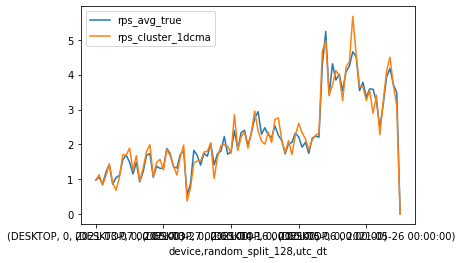

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


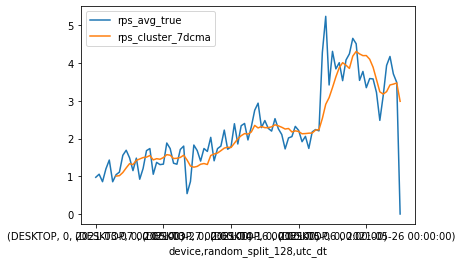

MOBILE


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


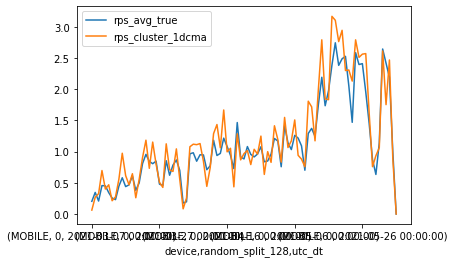

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


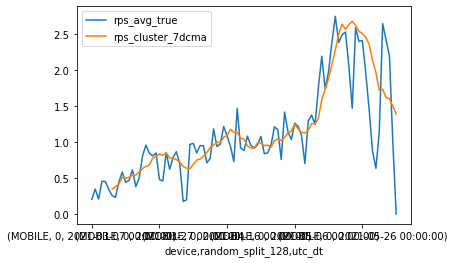

TABLET


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


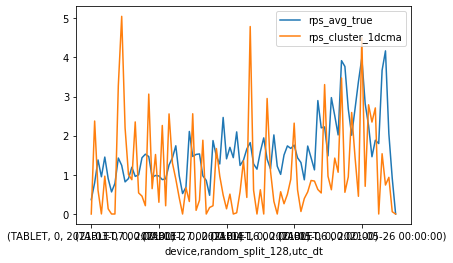

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


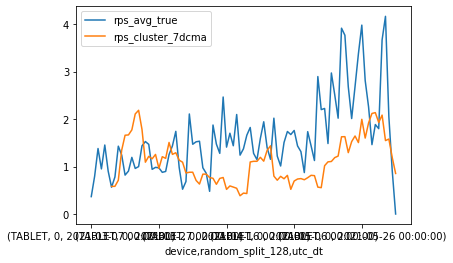

In [42]:
RPS_COL = "rps_cluster"
for device in rps_df.index.unique("device"):
    print(device)
    for window in (1,7):
        cma_windowC = [f"{RPS_COL}_{window}dcma"]
        rps_df.loc[(device,0,slice(None)),["rps_avg_true",*cma_windowC]].plot()
    #     rps_df.loc[(device,0,slice(None)),["rps_avg_true",*windowC[2:]]].plot()
        plt.show()

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


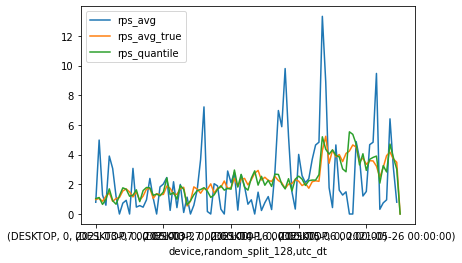

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


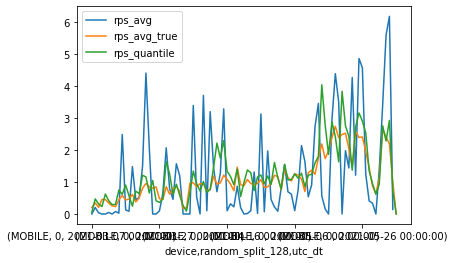

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


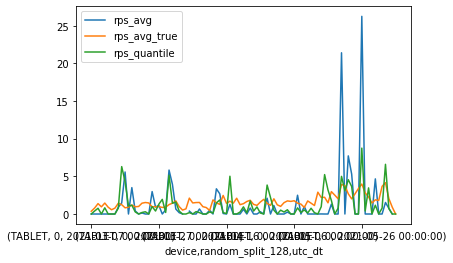

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


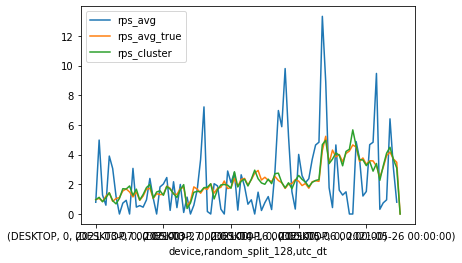

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


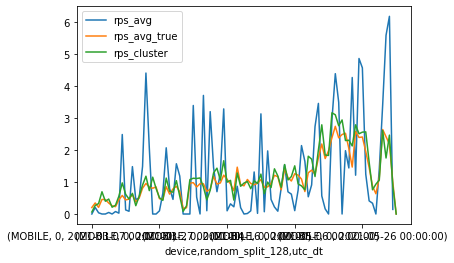

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


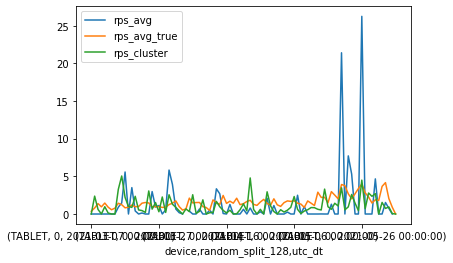

In [43]:
for RPS_COL in ["rps_quantile","rps_cluster"]:
    for device in rps_df.index.unique("device"):
        window = 1
        cma_windowC = [f"{RPS_COL}_{window}dcma"]
        rps_df.loc[(device,0,slice(None)),["rps_avg","rps_avg_true",RPS_COL]].plot()
        plt.show()

OK - basically I think that neither of the 2 conditions under which estimating rps from lead score is useful are met - these are 
1. more session w/ lead score than sessions w/ revenue - instead its the opposite -50k monetization events vs 30k lead scores...
2. a long history of lead score data that would alow us to take advantage of its time stability - we only have a couple months

Think further work will be unproductive until we can either 
1. score sessions w/ no survey (vast majority of session w/ survey have monetization b/c we auction off)
2. score sessions going further back
3. wait a little bit - maybe a couple months

### Alternate rps estimation approach
Goes back to original idea of stabilizing rps w/ lead score  - where you
1. 

In [5]:
split = BEST_SPLIT
rps_mu = wavg(rps_df["rps_avg"],rps_df["sessions"])
rps_split_mu = rps_df["rps_avg"] \
    .groupby(campaign_split_fields[split]) \
    .agg(get_wavg_by(rps_df,"sessions"))
rps_date_mu = rps_df["rps_avg"] \
    .groupby("utc_dt") \
    .agg(get_wavg_by(rps_df,"sessions"))

rps_df["rps_est_date"] = pd.DataFrame(
    (rps_split_mu / rps_mu).values.reshape(-1,1) @ (rps_date_mu.values.reshape(1,-1)),
    columns=rps_date_mu.index,
    index=rps_split_mu.index
).stack()

MemoryError: Unable to allocate 483. GiB for an array with shape (254696, 254696) and data type float64

In [37]:
# product = O65
# df = agg_rps(start_date,end_date,product,traffic_source,("device","utc_dt",))
# print("|df|:",df.shape)
# import pandas as pd
# df = df.reindex(pd.date_range(start_date,end_date),level="utc_dt")
# print("|df|:",df.shape)

In [77]:
import sklearn.linear_model

X = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]]
W = rps_df["sessions"].fillna(0)
y = rps_df["rps_avg"].fillna(0)

X = X.fillna(wavg(X,W))
X = (X - X.mean()) / X.std()
reg = sklearn.linear_model.LinearRegression() \
    .fit(X=X,y=y,sample_weight=W)

rps_df["rps_est_score"] = reg.predict(X)

rps_df

In [ ]:
"""

"""

/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


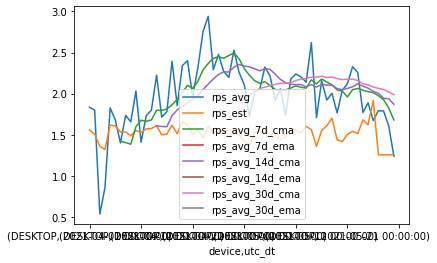

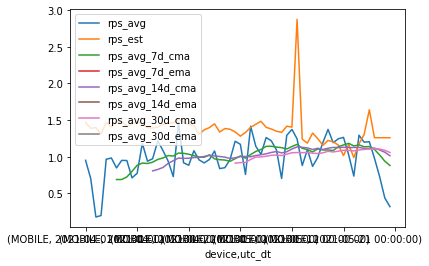

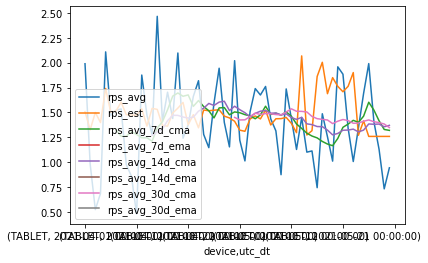

In [38]:
ma_fields = []
for N in [7,14,30]:
    ma_fields += [f"rps_avg_{N}d_cma",f"rps_avg_{N}d_ema"]
import numpy as np
df[ma_fields] = np.NaN
for i in df.index.unique(level=0):
    i = (i,slice(None))
    for N in [7,14,30]:
        df.loc[i,f"rps_avg_{N}d_cma"] = df.loc[i,"rps_avg"].rolling(N).mean()
#         df.loc[i,f"rps_avg_{N}d_ema"] = df.loc[i,"rps_avg"].ewm(com=(N+1)/2).mean()
    df.loc[i,["rps_avg","rps_est",*ma_fields]].plot()

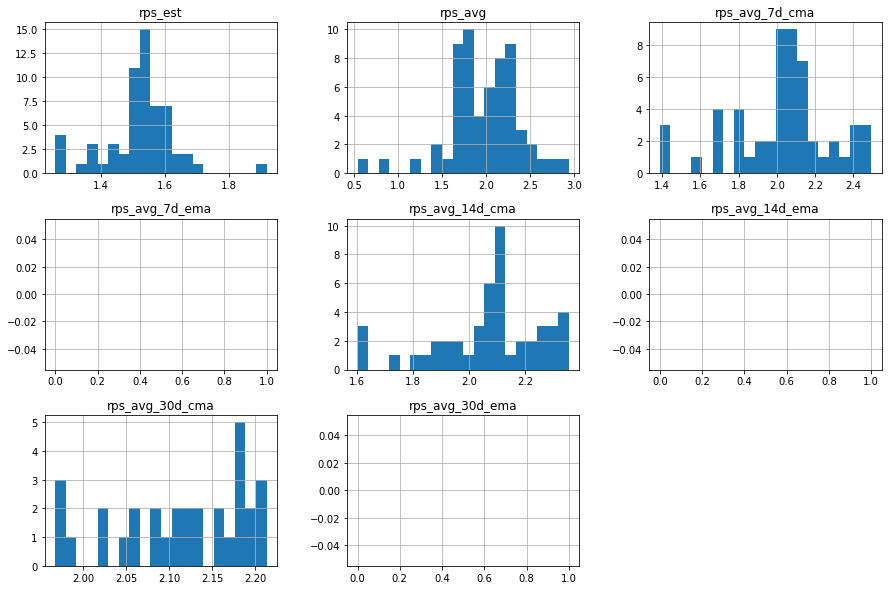

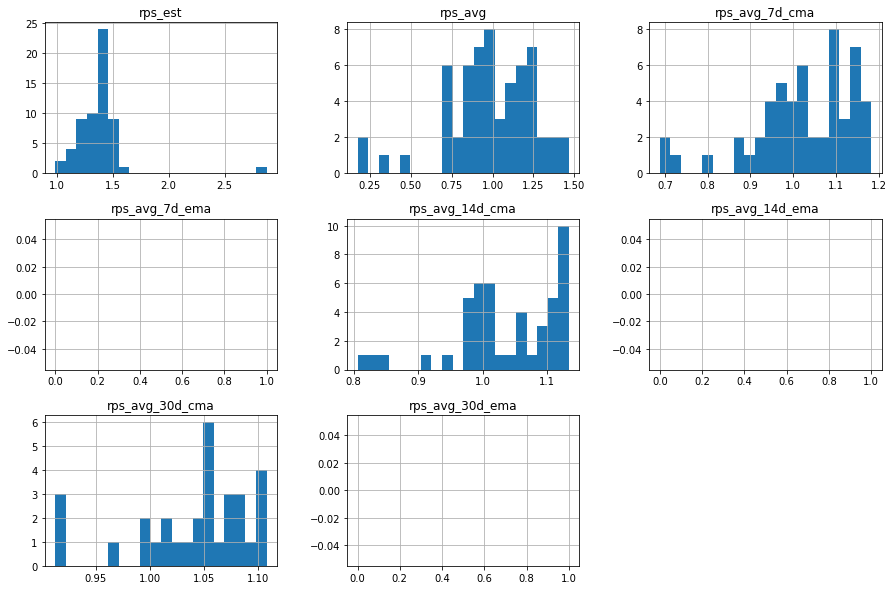

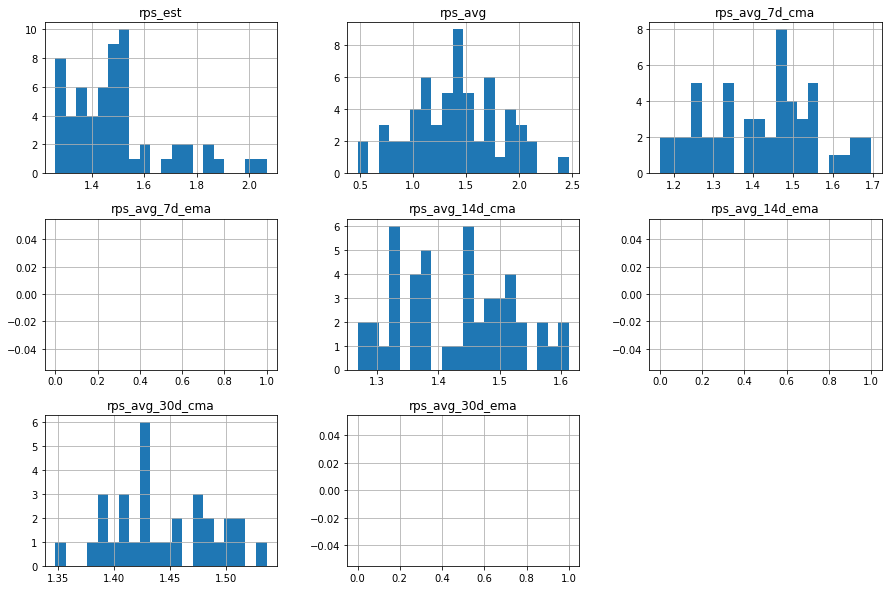

In [39]:
for i in df.index.unique(level=0):
    i = (i,slice(None))
    df.loc[i,["rps_est","rps_avg",*ma_fields]].hist(figsize=(15,10),bins=20)

In [ ]:

campaign_split_fields = dict(
    # traffic_source = ["traffic_source"],
    browser = ["browser"],
    operating_system = ["operating_system"],
    device = ["device"],
    # channel = ["channel"],
    # domain = ["domain"],
    product = ["product"],
    # keyword = ["keyword"],
    # campaign_id = ["campaign_id"],
    # landing_page = ["landing_page"],
    TOD = ["dayofweek","hourofday"],
    dma = ["dma"],
    state =["state",],
    location = ["state","dma"],
    
    dma_os=["dma", "operating_system"],
    dma_device=["dma", "device", ],
    dma_os_device=["dma", "operating_system", "device"],

    state_os=["state", "operating_system"],
    state_device=["state", "device", ],
    state_os_device=["state", "operating_system", "device"],

    location_os = ["state", "dma", "operating_system"],
    location_device=["state", "dma", "device", ],
    location_os_device = ["state", "dma", "operating_system","device"],
)

taboola_val_map = {
    "device": {
        'DESKTOP': 'DESK',
        'MOBILE': 'PHON',
        'TABLET': 'TBLT',
    },
    "operating_system": {
        'Linux armv7l': "Linux",
        'Linux armv8l': "Linux",
        'Linux x86_64': "Linux",
        'MacIntel': 'Mac OS X',
        'Win32': "Windows",
        'iPad': "iPadOS",
        'iPhone': "iOS",
        '': None,
        'ARM': None,
        'Android': 'Android',
        'Linux aarch64': "Linux",
        'Win64': "Windows",
        'Linux armv7': "Linux",
        'Linux i686': "Linux",
        'Windows': "Windows",
    }
}

def translate_taboola_vals(df):
    index_cols = df.index.names
    df = df.reset_index()
    for c in df.columns:
        if c in taboola_val_map:
            df[c] = df[c].apply(taboola_val_map[c].__getitem__)
    df_bkp = df
    df = df \
        .groupby(index_cols) \
        .agg({
            "sessions": sum,
            "num_leads": sum,
            "lps_avg": get_wavg_by(df,"sessions"),
            "rpl_avg": get_wavg_by(df,"sessions"),
            "rps_avg": get_wavg_by(df,"sessions"),
        })
    df["int_ix"] = range(len(df))
    df_bkp_wavg = wavg(df_bkp[["lps_avg","rpl_avg","rps_avg"]],
                        df_bkp["sessions"].values.reshape(-1, 1))
    df_wavg = wavg(df[["lps_avg","rpl_avg","rps_avg"]],
                    df["sessions"].values.reshape(-1, 1))
    assert all((df_bkp_wavg - df_wavg).abs() < 1e-2), (df_bkp_wavg,df_wavg)
    return df

import pprint
from IPython.display import display as ipydisp    
import pandas as pd
from models.utils import wavg
import collections
import itertools

def wvar(V,W):
    mu = wavg(V,W)
    var = wavg((V - mu)**2,W)
    return var
def wstd(V,W):
    return wvar(V,W)**0.5
def get_wavg_by(df, col):
    def wavg_by(V):
        return wavg(V, W=df.loc[V.index, col])
    return wavg_by

def get_wthresh(W,p):
    W = rps_df["sessions"].sort_values(ascending=False)
    Wsum = W.sum()
    cumsum = 0
    for wthresh in W:
        if cumsum > Wsum * p:
            break
        cumsum += wthresh
    return wthresh

"""
TODO: 2021-05-20
  - test fitting on general traffic sources?
  - test clustering on multiple days of rps data - 
      or rolling rps data or something
  - try out more granular aggs
  - is there some kind of metric which measures total variance
      and computes how much of that variance is captured by a split?

Trevor: 2021-05-21
TODO:
- figure out how to minimize campaign # when writing back to taboola
    - want to make sure campaigns have sufficient traffic
- kw=(location,os,device)
- calc 30-day rps/kw
- can create distribution over the rps(kw) distribution
- 100 campaigns - 1 per percentile

TODO: 2021-05-24
- look into clustering each individual split variable
"""

# split2aggrps = {}
# for split,split_cols in campaign_split_fields.items():
#     print(split,split_cols)
#     rps_df = agg_rps(NOW-90*DAY,NOW,None,traffic_source=TABOOLA,agg_columns=split_cols)
#     rps_df = translate_taboola_vals(rps_df)
#     rps_df["split_on"] = split
#     split2aggrps[split] = rps_df
#     print(split,rps_df.shape)


def agg_rps_taboola(start_date, end_date, product, traffic_source, agg_columns):
    rps_df = agg_rps(start_date,end_date,product=product,traffic_source=traffic_source,agg_columns=agg_columns)
    rps_df = translate_taboola_vals(rps_df)
    rps_df["split_on"] = split

split2fitaggrps = {}
for split,split_cols in campaign_split_fields.items():
    print(split,split_cols)
    rps_df = agg_rps(NOW-90*DAY,NOW-30*DAY,None,traffic_source=TABOOLA,agg_columns=tuple(split_cols))
    rps_df = translate_taboola_vals(rps_df)
    rps_df["split_on"] = split
    split2fitaggrps[split] = rps_df

    print(split,rps_df.shape)

split2evalaggrps = {}
for split,split_cols in campaign_split_fields.items():
    print(split,split_cols)
    rps_df = agg_rps(NOW-30*DAY,NOW,None,traffic_source=TABOOLA,agg_columns=tuple(split_cols))
    rps_df = translate_taboola_vals(rps_df)
    rps_df["split_on"] = split
    split2evalaggrps[split] = rps_df

    print(split,rps_df.shape)


In [ ]:

import sklearn.cluster
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
def cluster_split(split):
    rps_df_fit = split2fitaggrps[split]
    rps_df_eval = split2evalaggrps[split]
    split_size = rps_df_fit.__len__()
    MINCLUST = 8
    if split_size <= MINCLUST:
        rps_clust_df = rps_df_eval
        rps_df_fit["clust"] = 0
        rps_df_eval["clust"] = 0
    else:
        # nclust = MINCLUST
        nclust = max(MINCLUST, int(np.log(split_size)))
        # nclust = max(MINCLUST,int(split_size ** 0.5))
        # print("nclust", nclust, split_size, np.log(split_size))
        clusterer = sklearn.cluster.KMeans(n_clusters=nclust)
        rps_df_fit["clust"] = clusterer \
            .fit_predict(
                rps_df_fit["rps_avg"].values.reshape(-1, 1),
                sample_weight=rps_df_fit["sessions"])
        rps_df_eval["clust"] = clusterer \
            .predict(
                rps_df_eval["rps_avg"].values.reshape(-1, 1),
                sample_weight=rps_df_eval["sessions"])
        rps_clust_df = rps_df_eval \
            .groupby("clust") \
            .agg({"rps_avg": get_wavg_by(rps_df_eval, "sessions"), "sessions": sum})
    assert rps_clust_df["rps_avg"].max() <= rps_df_eval["rps_avg"].max()
    rps_wavg = wavg(rps_df_eval["rps_avg"], rps_df_eval["sessions"])
    rps_clust_wavg = wavg(rps_clust_df["rps_avg"], rps_clust_df["sessions"])
    assert abs(rps_wavg - rps_clust_wavg) < 1e-4, (rps_wavg, rps_clust_wavg)
    return rps_df_fit,rps_df_eval,rps_clust_df

def get_split_factor(rps_df):
    orig_index = rps_df.index.names
    split_attr2unique_vals = {index_col: rps_df.index.unique(
        index_col) for index_col in orig_index}
    _,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
    nclusts = rps_df["clust"].unique().__len__()
    split_factor = nclusts * np.prod([1] + [split_attr2unique_vals[c].__len__() for c in new_index_order[:-1]])
    return split_factor

perfD = []
for split in campaign_split_fields.keys():
    rps_df_fit,rps_df_eval,rps_clust_df = cluster_split(split)
    perfd = {
        "split": split,
        "fit_shape": rps_df_fit.shape,
        "clust_shape": rps_clust_df.shape,
        # wavg(rps_df["rps_avg"],rps_df["sessions"]),
        "split_variance": wstd(rps_df_eval["rps_avg"], rps_df_eval["sessions"]),
        "cluster_variance": wstd(rps_clust_df["rps_avg"], rps_clust_df["sessions"]),
        # wstd(rps_df["rps_avg"],rps_df["sessions"])
        "split_factor": rps_df_fit.__len__(),
        "clustered_split_factor": get_split_factor(rps_df_fit),
    }
    perfD.append(perfd)
    pprint.pprint(perfd)
    ipydisp(rps_clust_df)

perfdf = pd.DataFrame(perfD)
ipydisp(perfdf)
#%%
# BEST_SPLIT = "location_os_device"
BEST_SPLIT = "dma_os_device"
# BEST_SPLIT = "dma_os"

rps_df_fit, rps_df_eval, rps_clust_df = cluster_split(BEST_SPLIT)
rps_df = rps_df_fit
get_split_factor(rps_df)
orig_index = rps_df.index.names
split_attr2unique_vals = {index_col: rps_df.index.unique(index_col) for index_col in orig_index}
_,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
rps_df = rps_df .reset_index()
campaign_df = rps_df \
    .groupby([*new_index_order[:-1], "clust"]) \
    .agg({
        "sessions": sum,
        "rps_avg": get_wavg_by(rps_df,"sessions"),
        new_index_order[-1]: tuple
    })
assert campaign_df["sessions"].sum() == rps_df_fit["sessions"].sum()
camp_rps_wavg = wavg(campaign_df["rps_avg"],campaign_df["sessions"])
fit_rps_wavg = wavg(rps_df_fit["rps_avg"], rps_df_fit["sessions"])
assert abs(camp_rps_wavg - fit_rps_wavg) < 1e-5

excl_campaign_df = campaign_df.groupby([*new_index_order[:-1]]) \
    .agg({
        new_index_order[-1]: tuple
    })
def flatten(M):
    return tuple(el for r in M for el in r)
excl_campaign_df[new_index_order[-1]] = excl_campaign_df[new_index_order[-1]] .apply(flatten)

camps = []
for idx,r in campaign_df.iterrows():
    camp = {
        "sessions_60d": r["sessions"], 
        "rps_avg_60d": r["rps_avg"]
    }
    for field,val in zip(new_index_order[:-1],idx):
        camp[field] = {"includes": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "includes": r[last_field]
    }
    camps.append(camp)

for idx, r in excl_campaign_df.iterrows():
    camp = {}
    for field, val in zip(new_index_order[:-1], idx):
        camp[field] = {"includes": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "excludes": r[last_field]
    }
    camps.append(camp)

camp_df = pd.DataFrame(camps)
camp_df.to_csv("campaign_dump.csv")
#%%

import numpy as np
import pandas as pd
import scipy.stats
import sklearn.feature_selection
import sklearn.metrics
from matplotlib import pyplot as plt
import sklearn.preprocessing

requires_campaign_split = [
    # "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]

for split in requires_campaign_split:
    rps_df = split2aggrps[split] .reset_index()
    Xs = rps_df \
        .apply(lambda r: [r["int_ix"]]*int(r["sessions"]), axis=1)
    X = np.concatenate(Xs.values).reshape(-1,1)
    ys = rps_df \
        .apply(lambda r: [r["rps_avg"]]*int(r["sessions"]),axis=1)
    y = np.concatenate(ys.values)
    # print(y.min(),np.quantile(y, 0.5),y.max())
    y = y > y.mean()
    # y = np.concatenate(ys.values).reshape(-1,1)
    # y = sklearn.preprocessing.KBinsDiscretizer(n_bins=2,encode="ordinal") \
    #     .fit_transform(y).reshape(-1)
    mi = sklearn.feature_selection.mutual_info_regression(X,y,discrete_features=True)
    print(split,mi,y.mean(),rps_df.shape)
#%%
y
#%%
sklearn.metrics.mutual_info_score

#%%
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt

requires_campaign_split = [
    "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]
combined_rps_df = pd.concat([df.reset_index() for df in split2aggrps.values()])
splitI = combined_rps_df["split_on"].isin(requires_campaign_split)
density = scipy.stats.gaussian_kde(
    dataset=combined_rps_df.loc[splitI,"rps_avg"],
    weights=combined_rps_df.loc[splitI, "sessions"],
    # bw_method="scott",
    # bw_method="silverman",
    # bw_method=0.1,
)
xs = np.linspace(0,2,100)
plt.plot(xs,density(xs))
#%%
for split in requires_campaign_split:
    splitI = combined_rps_df["split_on"] == split
    density = scipy.stats.gaussian_kde(
        dataset=combined_rps_df.loc[splitI, "rps_avg"],
        weights=combined_rps_df.loc[splitI, "sessions"])
    xs = np.linspace(0, 2, 100)
    plt.plot(xs, density(xs))
    plt.title(split)
    plt.show()
#%%
combined_rps_df.loc[splitI, ["rps_avg","sessions"]].apply(
        lambda r: pd.Series([r["rps_avg"]]*int(r["sessions"])),axis=1) \
    .unstack()
#%%
agg_rps = split2aggrps["TOD"]
Xy = agg_rps[["sessions","rps"]].reset_index()
Xy["i"] = range(len(Xy))
Xy
#%%
import sklearn.feature_selection
sklearn.feature_selection.mutual_info_regression(
    []
)

#%%
"""
- 
- overall goal:
    - specific ROI targetting w/ minimal campaigns
- what this means for accnt structure
    - for many variables we must split campaigns to target ROI
    - want to capture greatest amt of rps variation w/ 
        fewest # of campaigns
- 2 ways of approaching this
    1. minimize rps variation w/in a campaign
        - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
        - tried this out a little - but the computation was intensive which made it slow going
    2. maximize rps variation outside campaigns
    - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    - mostly focused on this approach

- approaches I tried
1. rank splits by their correlation/covaraince/MI w/ `agg_rps`
    - tried ANOVA,pt.biserial,MI - had most success w/ MI
    - was dificult to compute b/c couldnt find methods that accepted sample weight
    - MI approach was promising but didnt go down that route
2. rank splits by intra-split agg_rps variance
    - had most success w/ this
    - tested out an approahc where I cluster the split on rps - had good results
    - think this is the mtd to use going forward
    TODO:
    - test fitting on general traffic sources?
    - test clustering on multiple days of rps data - 
        or rolling rps data or something
    - try out more granular aggs
    - is there some kind of metric which measures total variance
        and computes how much of that variance is captured by a split?

3. fit decision tree on rps data 
    - MSE criterion is apparently the same as minimizng inter split variance
    - computationally intensive
    - not 100% clear how to go from tree to campaign structure


- can do this by
    1. choosing what vars or tuples of vars to split campaigns on
    2. grouping similar buckets w/in those splits
- want to measure correlation/dependence of categorical split vars w/ cont rps
    - cat,cat metrics w/ binned rps
        chi
    - cont,cont metrcs w/ 1 hot encoded split vars
    - cat,cont metrics
- correlation metrics
    - MI:
        - sklearn.feature_selection.mi_regression
        - would need AFAICT to rresample input arrays
    - ANOVA:
        - scipy.stats.f_oneway
    - pt biserial
        - needs binary vars tho
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html
        - https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
- want most variation of rps w/ fewest camapaigns
- dont want to group similar buckets together - think its too complicated

"""
#%%
requires_campaign_split = [
    "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    "domain",
    "product",
    "landing_page",
    "location",
]
#%%

traffic_source = TABOOLA
with HealthcareDW() as db:
    traffic_filter = "" if traffic_source is None else \
        f"AND UPPER(traffic_source) = UPPER('{traffic_source}')"
    sql = f"""
    select
        traffic_source,domain,count(*)
    from tracking.session_detail
    where True 
    {traffic_filter}
    group by traffic_source,domain;
    """
    df = db.to_df(sql).sort_values("count")
df
#%%

# %%
with HealthcareDW() as db:


In [ ]:
# Header

